# Customer Behavior to Drive Sales 

This notebook is to be submitted for "Project 4: Write A Data Science Blog Post" as part of [Udacity's Data Scientist Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree). In this project, I am tasked with choosing a dataset, identifying three questions, and analyzing the data to find answers to these questions while following [CRISP-DM Process](https://www.ibm.com/support/knowledgecenter/en/SS3RA7_15.0.0/com.ibm.spss.crispdm.help/crisp_overview.htm). I am then tasked with writing a blog post in which I communicate findings to non-technical audience.

## 1. Business Understanding

The dataset in use has been provided by supermarket company detailing their sales activities. The task is to find some insights that can help them improve their sales and marketing strategies.

Three questions were proposed:
* What quantities at which gender-specific customers generate more gross income?
* How payment method affect gender-specific customer experience?
* What day of the week product lines generates more gross income?

## 2. Data Understanding

In [153]:
# importing necessary libraries
import numpy as np
import pandas as pd

from IPython.display import display

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings(action='once')

In [154]:
# reading supermarket_sales data
df = pd.read_csv('supermarket_sales.csv')
print('(rows, columns):', df.shape)

(rows, columns): (1000, 17)


**Attribute Information:**  
1. `Invoice id`: Computer-generated nvoice identification number.  
2. `Branch`: Supercenter branch.
3. `City`: Supercenters location.
4. `Customer type`: Type of customers, members are member card holder and normal without member cards.  
5. `Gender`: Gender type of customer.
6. `Product line`: General item categorization groups.
7. `Unit price`: Price of each product in U.S. Dollars.
8. `Quantity`: Number of products purchased by customer.  
9. `Tax`: 5% tax fee on total amount. 
10. `Total`: Total price including tax. 
11. `Date`: Date of purchase.  
12. `Time`: Purchase time.
13. `Payment`: Payment method used by customer for purchase.  
14. `COGS`: Cost of goods sold.
15. `Gross margin percentage`: Gross margin percentage.
16. `Gross income`: Gross income.
17. `Rating`: Customer stratification rating for shopping experience (On a scale of 1 to 10).

In [155]:
# exploring data
df.head(10)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
5,699-14-3026,C,Naypyitaw,Normal,Male,Electronic accessories,85.39,7,29.8865,627.6165,3/25/2019,18:30,Ewallet,597.73,4.761905,29.8865,4.1
6,355-53-5943,A,Yangon,Member,Female,Electronic accessories,68.84,6,20.6520,433.6920,2/25/2019,14:36,Ewallet,413.04,4.761905,20.6520,5.8
7,315-22-5665,C,Naypyitaw,Normal,Female,Home and lifestyle,73.56,10,36.7800,772.3800,2/24/2019,11:38,Ewallet,735.60,4.761905,36.7800,8.0
8,665-32-9167,A,Yangon,Member,Female,Health and beauty,36.26,2,3.6260,76.1460,1/10/2019,17:15,Credit card,72.52,4.761905,3.6260,7.2
9,692-92-5582,B,Mandalay,Member,Female,Food and beverages,54.84,3,8.2260,172.7460,2/20/2019,13:27,Credit card,164.52,4.761905,8.2260,5.9


## 3. Data Preparation

In [156]:
df.columns

Index(['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender',
       'Product line', 'Unit price', 'Quantity', 'Tax 5%', 'Total', 'Date',
       'Time', 'Payment', 'cogs', 'gross margin percentage', 'gross income',
       'Rating'],
      dtype='object')

Not all columns are needed in this analysis. Based on the questions proposed, only columns `Gender`, `Product line`, `Quantity`, `Date`, `Time`, `Payment`, `gross income`, and `Rating` are needed.

Also, since the objective of this analysis is quite simple and no application of machine learning will be used, and [with seaborn's capability to handle categorical variables](https://seaborn.pydata.org/tutorial/categorical.html), no further action will be taken on categorical variables and will be used as it is. Obviously, this saves the time and effort of encoding categorical variables and having to remap them again when plotting graphs.

In [157]:
# regenerating df with only necessary columns
df = df[['Gender', 'Product line', 'Quantity', 'Date', 'Time', 'Payment', 'gross income', 'Rating']]

# renaming columns for usability purposes
df.columns = ['gender', 'product_line', 'quantity', 'date', 'time', 'payment', 'gross_income', 'rating']

df.columns

Index(['gender', 'product_line', 'quantity', 'date', 'time', 'payment',
       'gross_income', 'rating'],
      dtype='object')

In [158]:
def combine_date_time(data, date, time, drop=True, front=False):
    '''
    Takes two separate date and time columns
    and combine them into one datetime object column
    
    KEYWORD ARGUMENTS:
        # data -- DataFrame
            data source
            
        # date, time -- str
            names for date and time columns
            
        # drop -- bool, default: True
            if True, drops old date and time columns
            
        # front -- bool, default: False
            if True, brings new datetime columns to index 0
            
    OUTPUT:
        DataFrame with new datetime object column
        and old date and time columns dropped
    '''
    data['datetime'] = data[date] + ' ' + data[time]
    data.datetime = pd.to_datetime(data.datetime, infer_datetime_format=True)
    
    if drop == True:
        data.drop(columns=[date, time], inplace=True)
    
    if front == True:
        data = data.set_index('datetime').reset_index()

In [159]:
# converting date and time columns to one 'datetime' column
combine_date_time(df, 'date', 'time')

In [160]:
df.dtypes

gender                  object
product_line            object
quantity                 int64
payment                 object
gross_income           float64
rating                 float64
datetime        datetime64[ns]
dtype: object

In [161]:
# assessing missing values 
df.isnull().sum()

gender          0
product_line    0
quantity        0
payment         0
gross_income    0
rating          0
datetime        0
dtype: int64

No missing values in the data. No further action is necessary.

In [162]:
# defining a function to help in plotting graphs
def plot_grpah(figsize=(10,8), figtype=None, y=None, x=None, hue=None, labels=None, save=False):
    '''
    Plots y, x, and hue arrays using seaborn library
     
    KEYWORD ARGUMENTS:
        # figszie -- float, float, default: (10,8)
            (width, height) in inches

        # figtype -- str
            figure type, options: 'barplot', 'boxplot', and 'pointplot'
            
        # y, x, hue -- array
            inputs for plotting long-form data
            
        # labels -- list, default: None
            in order (figure_title, ylabel, xlabel, legend_title)
            
        # save -- bool, default: False
            save figure in 'png' format to main folder, uses figure's title as filename
    
    OUTPUT
        returns Axes object with the plot drawn onto it
    '''
    # plotting figure
    fig = plt.figure(figsize=figsize)
    
    if figtype == 'pointplot':
        ax = sns.pointplot(y=y, x=x, hue=hue)
    elif figtype == 'boxplot':
        ax = sns.boxplot(y=y, x=x, hue=hue)
    elif figtype == 'barplot':
        ax = sns.barplot(y=y, x=x, hue=hue, ci=False)
    else:
        print('figtype must be specified')
    
    # setting up labels
    fig = plt.title(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_xlabel(labels[2])
    fig = plt.legend(title=labels[3], loc='upper left', bbox_to_anchor=(1.0, 0.5), ncol=1)
    
    # exporting and showing figure
    if save == True:
        plt.savefig(fname=labels[0].replace(" ", "_").lower(), dpi=72, bbox_inches='tight')       
    
    plt.show()

## 4. ~~Modeling & Evaluating~~ Analysis

### 4.1. What quantities at which gender-specific customers generate more gross income?

To answer this question, a `pointplot` will be used with `gross_income` divided by `quantity` on the y-axis to get gross income per item, `quantity` on the x-axis, and hue to be `gender` as a grouping variable to distinguish the two groups from each other.

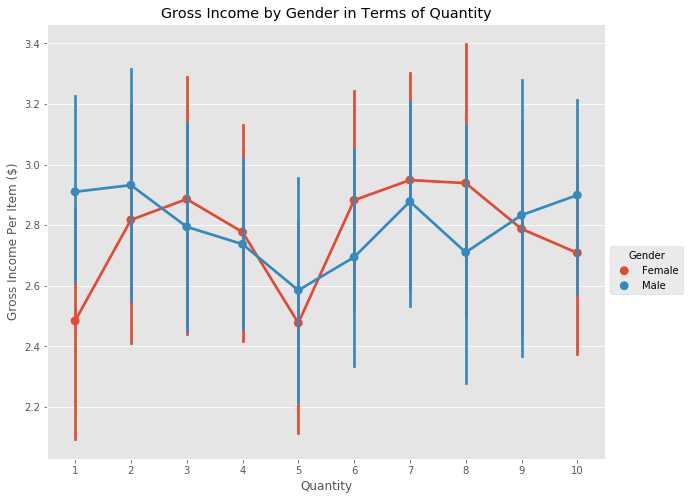

In [163]:
plot_grpah(
    figtype='pointplot', y=(df.gross_income/df.quantity), x=df.quantity, hue=df.gender, save=True,
    labels=['Gross Income by Gender in Terms of Quantity', 'Gross Income Per Item ($)', 'Quantity', 'Gender']
)

The graph shows that male customers generate more gross income per item when buying items at lower quantity. This is most clear at a quantity of 1. On the other hand, female customers tend to generate more gross income per item when buying at higher quantities. Clearly shown at quantities 6, 7, and 8.

### 4.2. How payment method affect gender-specific customer satisfaction?

To answer this question, a `boxplot` will be used with `rating` on y-axis, `payment` on the x-axis, and hue to be `gender` as a grouping variable to distinguish the two groups from each other.

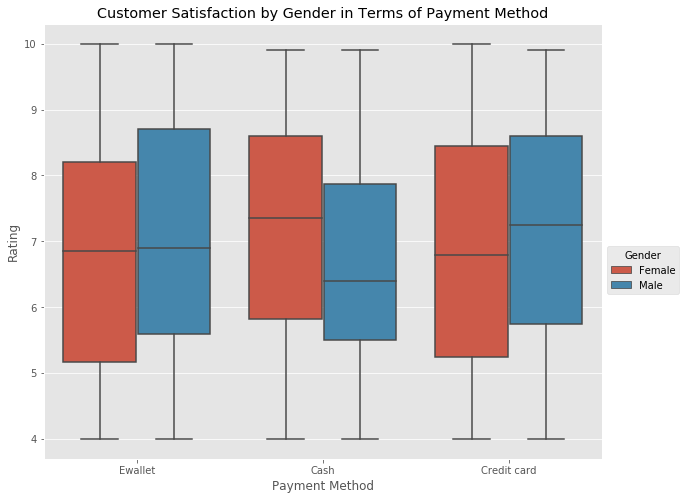

In [164]:
plot_grpah(
    figtype='boxplot', y=df.rating, x=df.payment, hue=df.gender, save=True,
    labels=['Customer Satisfaction by Gender in Terms of Payment Method', 'Rating', 'Payment Method', 'Gender']
)

The graph shows that male customers tend to give higher satisfaction ratings for shopping experience when they pay using e-wallets or credit cards. Female customers, contrarily, tend to give higher satisfaction ratings for shopping experience when paying in cash.

### 4.3. What day of the week on which certain product lines generate more gross income?

To answer this question, a `barplot` will be used with `gross_income` divided by `quantity` on the y-axis to get gross income per item, weekday will be extracted from `datetime` on the x-axis, and hue to be `product_line` as a grouping variable to distinguish groups from each other.

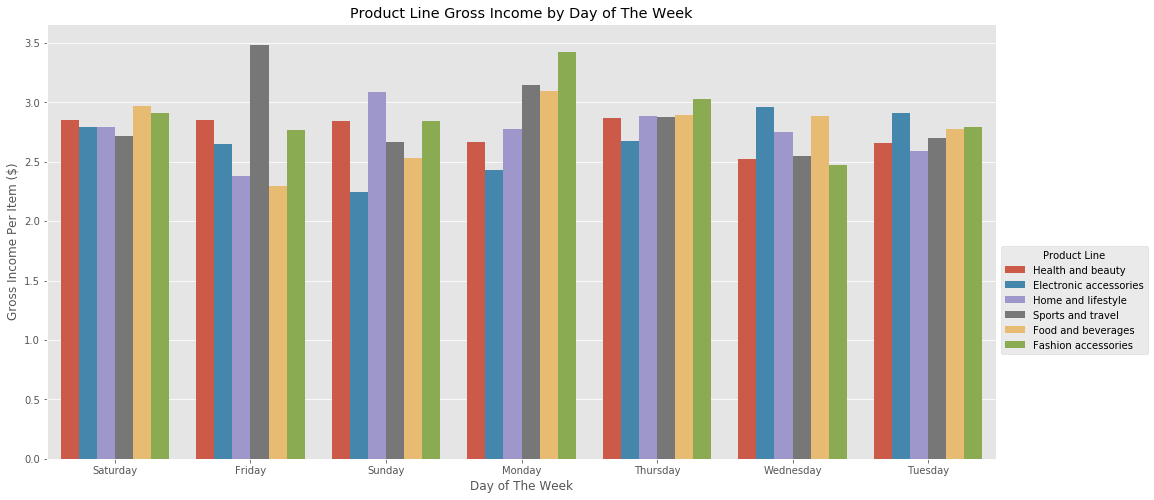

In [165]:
plot_grpah(
    figsize=(17,8), figtype='barplot', y=(df.gross_income/df.quantity), x=df.datetime.dt.weekday_name, hue=df.product_line,
    labels=['Product Line Gross Income by Day of The Week', 'Gross Income Per Item ($)', 'Day of The Week', 'Product Line'],
    save=True
)

The graph shows that best gross income per item on Mondays and Thursdays are _fashion accessories_ items, on Tuesdays and Wednesdays are _electronic accessories_ items, on Fridays are_sports and travel_ items, on Saturdays are _food and beverages_ items, and on Sundays are _home and lifestyle_ items. 

The graph also shows some interesting trends. For example, there is a significant increase in gross income per item on Fridays for _sport and travel_. Fridays also happen to be the worst day of the week for _home and lifestyle_ and _food and beverages_ items in terms of gross income per item. This might suggest a relationship between the three that should be investigated further.

## 5. Deployment

Notebook is available on [GitHub](https://github.com/alghsaleh/Customer-Behavior-to-Drive-Sales/blob/master/supermarket_sales.ipynb) and [Kaggle](https://www.kaggle.com/alghsaleh/customer-behavior-to-drive-sales). Blog post is available on [Medium](https://medium.com/@alghsaleh/customer-behavior-to-drive-sales-aaeeefb0b39e?source=friends_link&sk=2d1735c7229a5a0341547ffc1189fda7).